In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, BatchNormalization, Dropout, Flatten, Dense, Activation
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

In [2]:
!git clone https://github.com/Yuvnish017/Dynamic_Hand_Gesture_Recognition.git

Cloning into 'Dynamic_Hand_Gesture_Recognition'...
remote: Enumerating objects: 14870, done.
remote: Counting objects: 100% (14870/14870), done.
remote: Compressing objects: 100% (14612/14612), done.
remote: Total 14870 (delta 263), reused 14863 (delta 256), pack-reused 0
Receiving objects: 100% (14870/14870), 30.25 MiB | 24.53 MiB/s, done.
Resolving deltas: 100% (263/263), done.


In [3]:
X = []
Y = []

d = {'ClosingFist': 0,
     'LeftSwipe': 1,
     'OpeningFist': 2,
     'RightSwipe': 3,
     'SwipeDown': 4,
     'SwipeUp': 5,
     'ThumbsDown': 6,
     'ThumbsUp': 7}

datadir = 'Dynamic_Hand_Gesture_Recognition/dataset'
for classes in os.listdir(datadir):
  path = os.path.join(datadir, classes)
  for folder in os.listdir(path):
    m = np.zeros(shape=(30, 128, 128, 1))
    imgs = os.path.join(path, folder)
    for i, img in enumerate(os.listdir(imgs)):
      image = cv2.imread(os.path.join(imgs, img))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      image = np.array(image)
      image = np.expand_dims(image, axis=-1)
      image = image/255.
      m[int(int(os.path.splitext(img)[0])/5), :, :, :] = image
    X.append(m)
    Y.append(d[classes])

print(len(X))
print(len(Y))

480
480


In [4]:
X = X*2
Y = Y*2

0


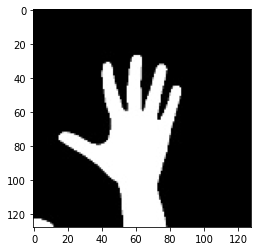

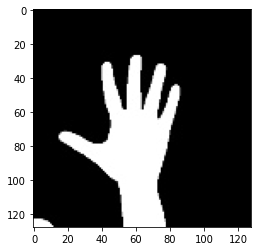

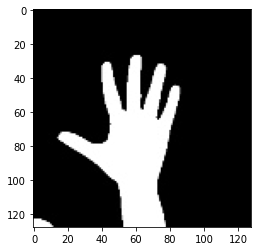

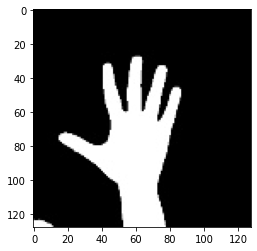

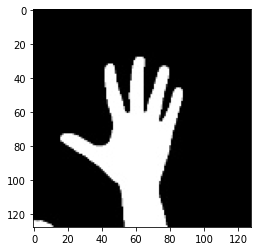

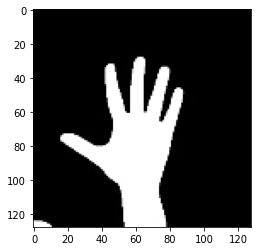

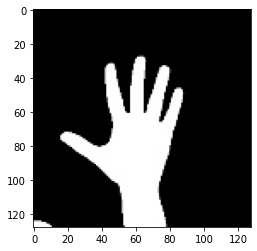

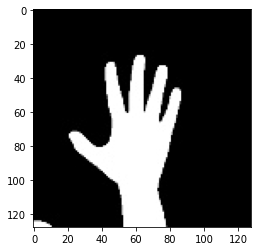

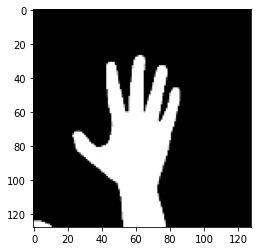

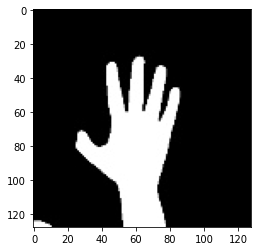

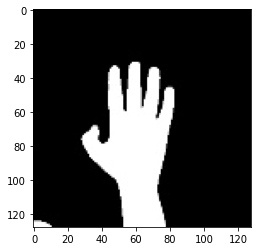

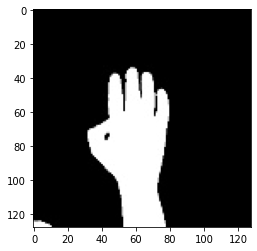

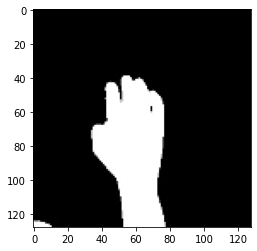

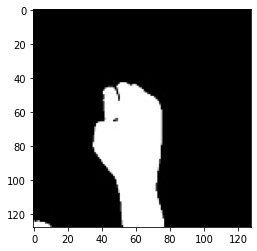

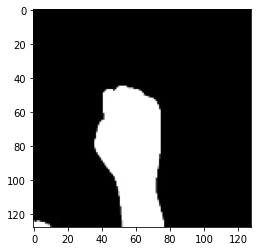

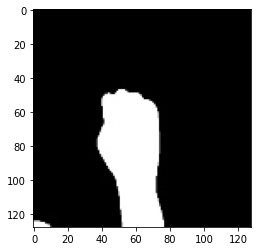

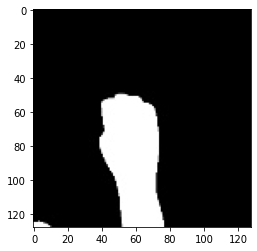

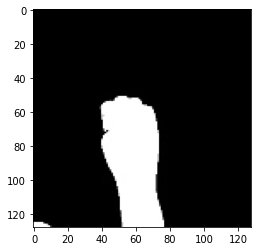

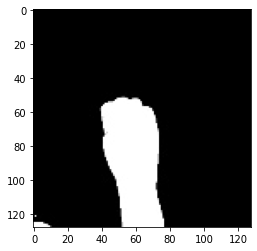

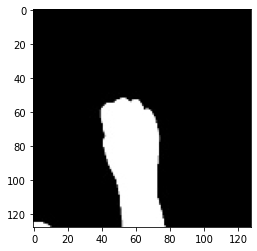

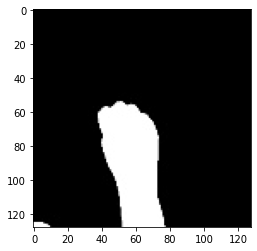

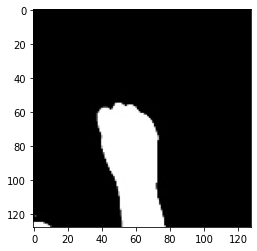

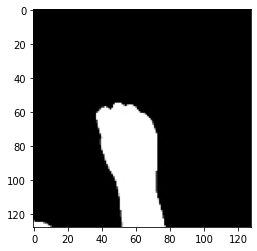

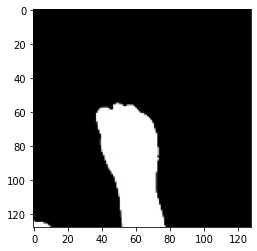

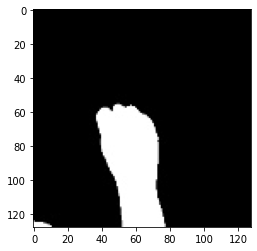

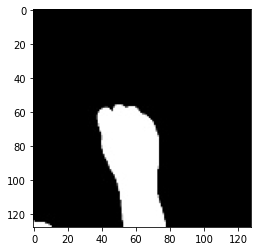

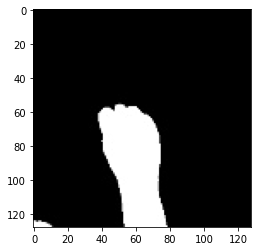

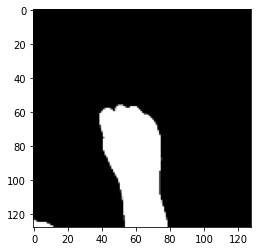

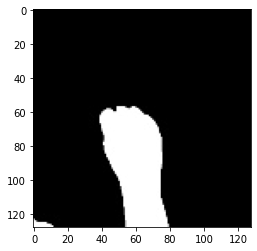

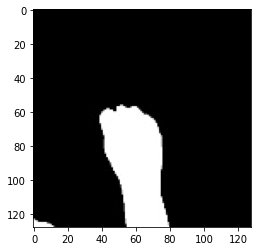

1


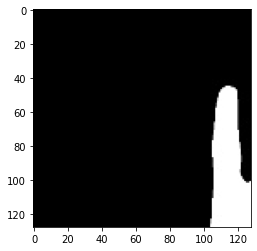

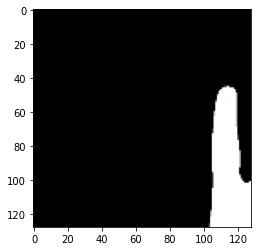

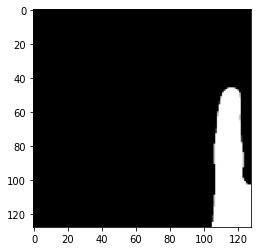

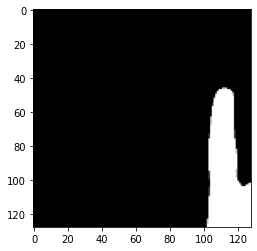

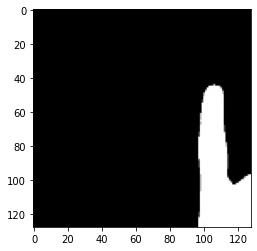

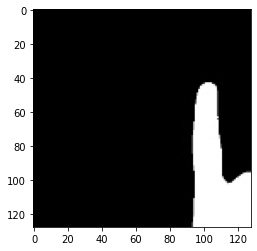

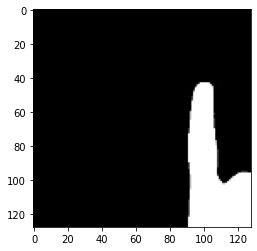

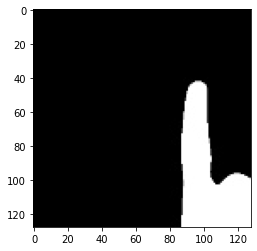

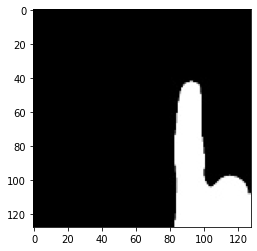

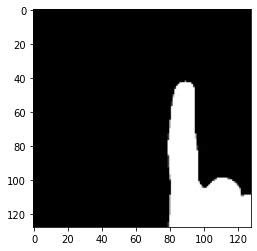

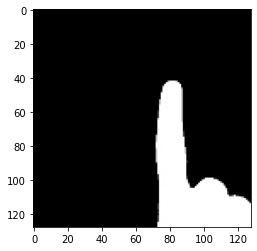

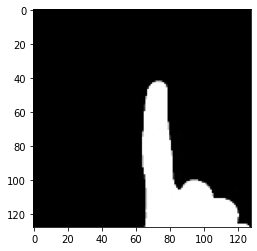

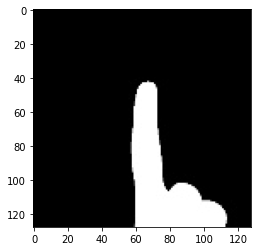

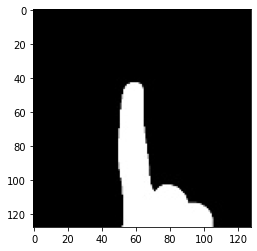

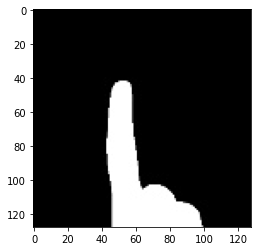

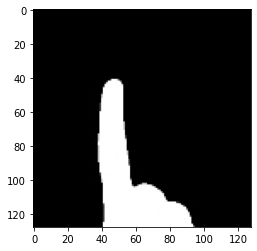

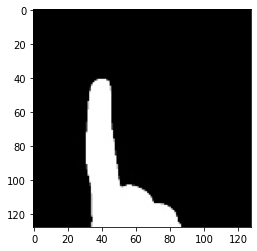

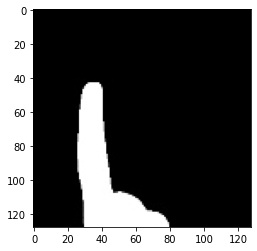

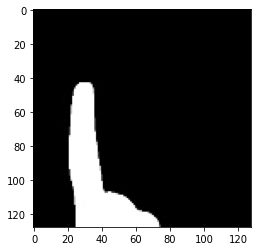

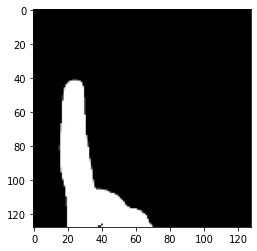

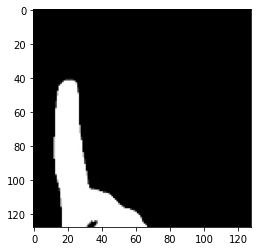

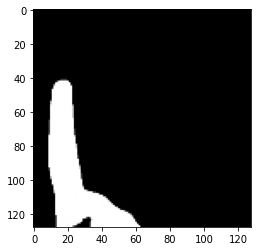

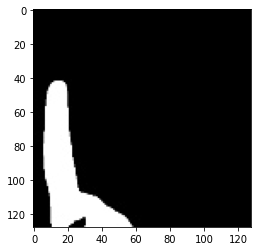

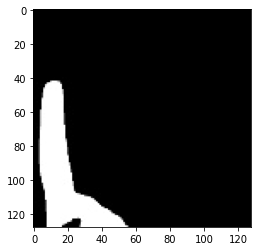

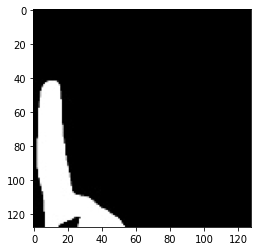

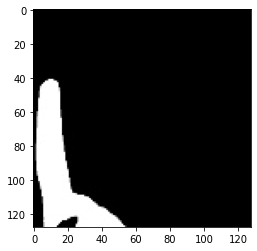

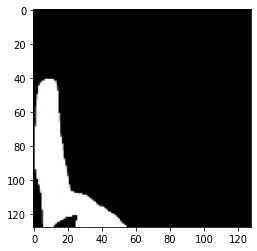

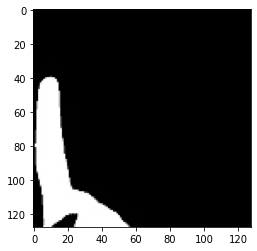

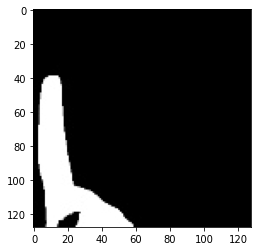

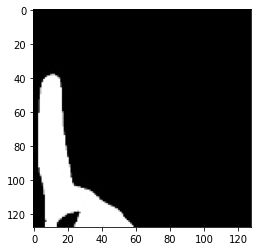

2


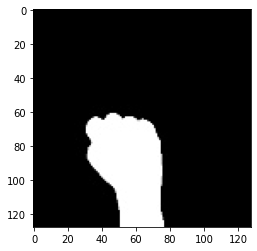

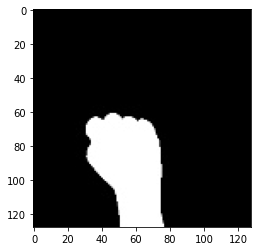

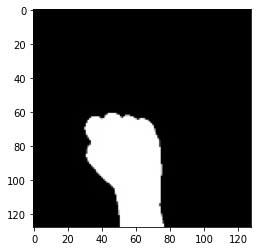

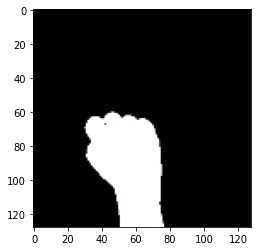

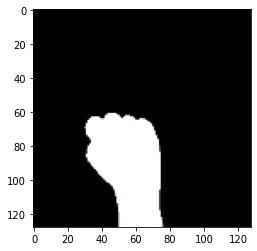

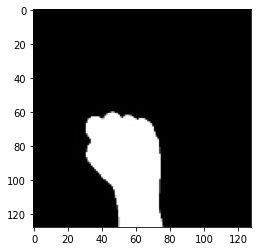

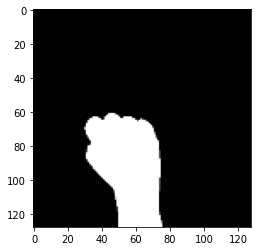

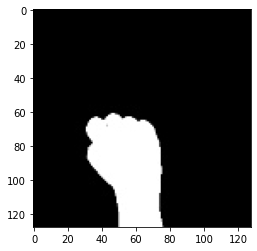

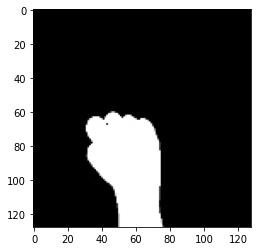

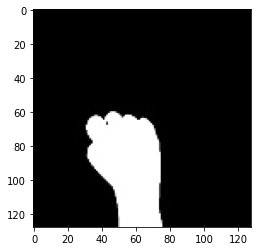

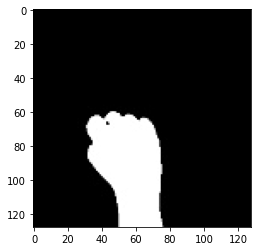

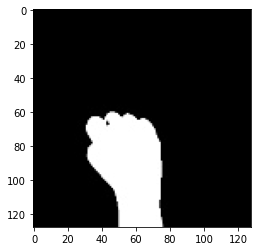

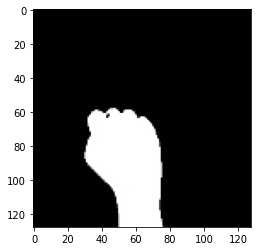

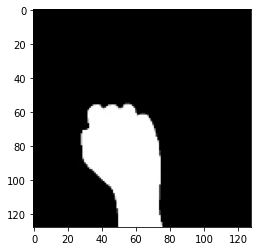

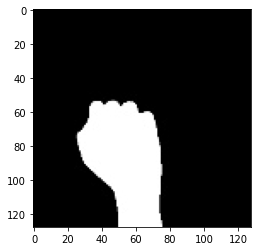

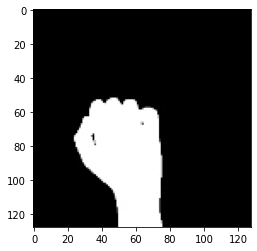

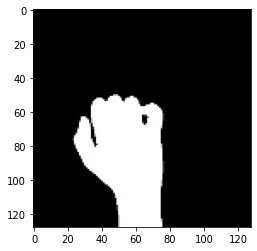

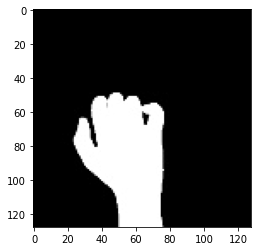

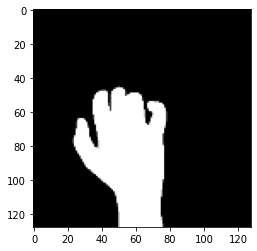

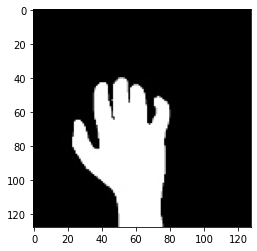

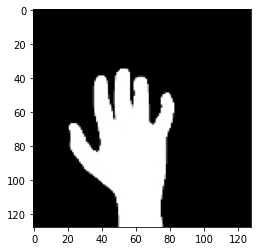

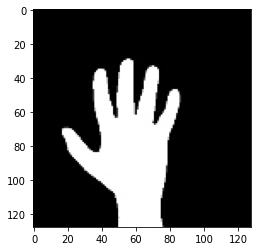

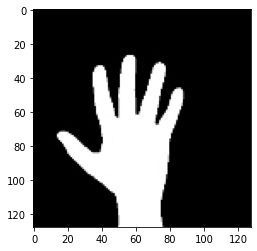

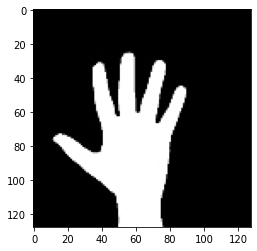

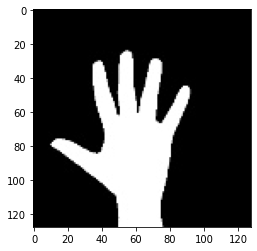

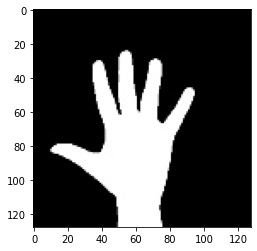

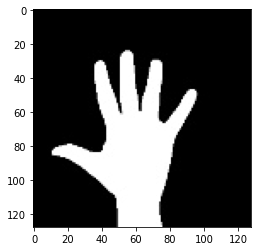

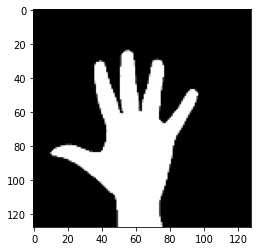

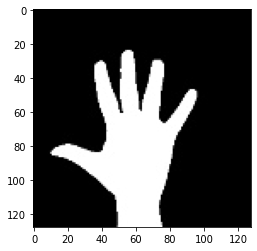

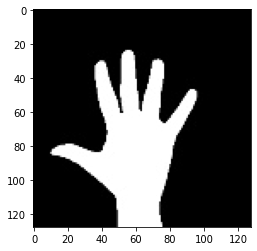

3


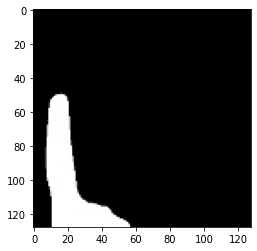

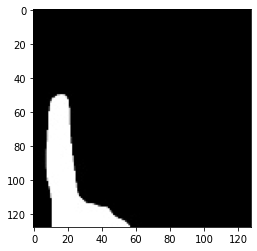

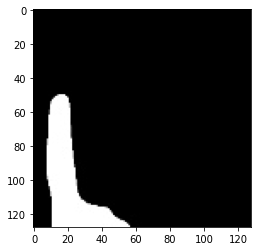

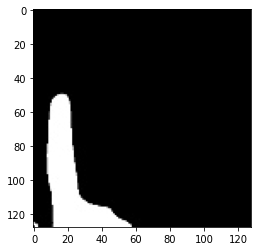

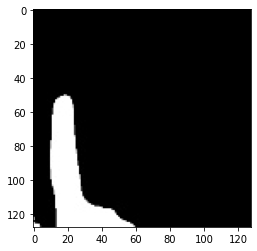

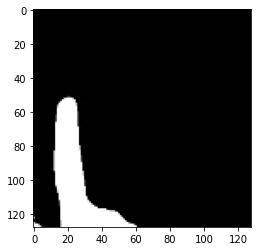

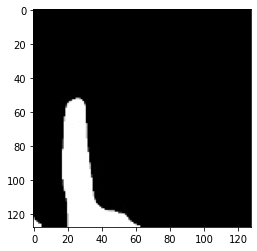

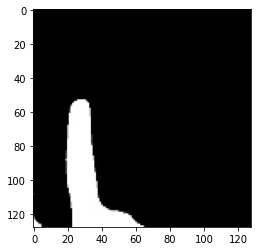

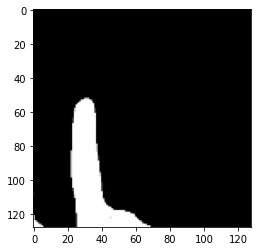

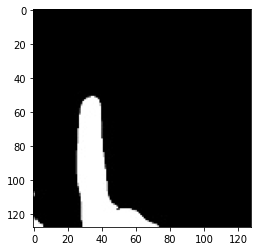

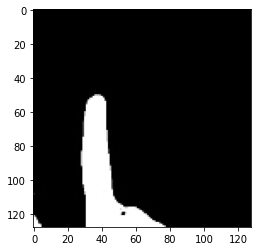

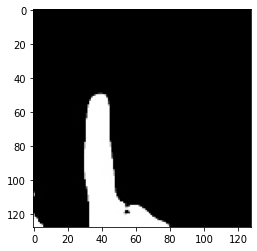

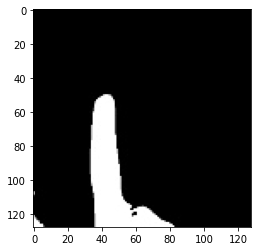

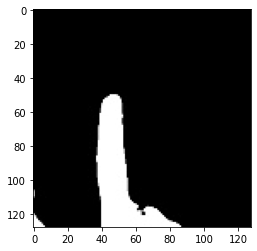

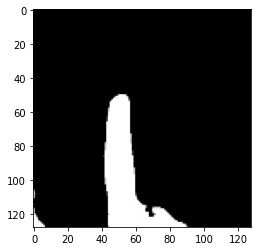

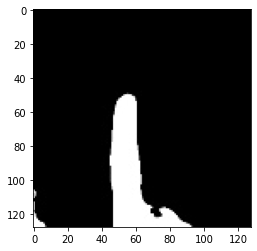

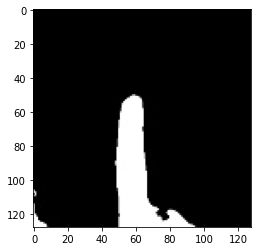

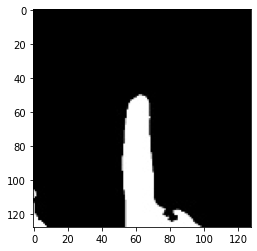

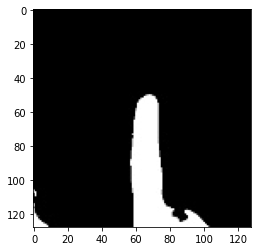

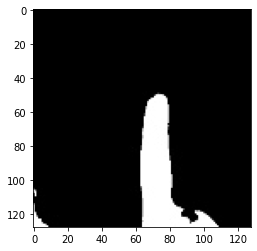

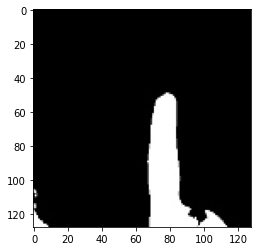

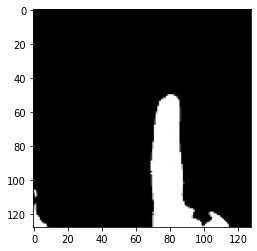

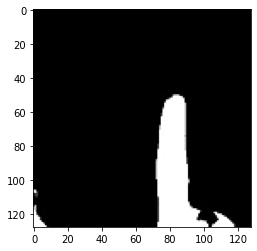

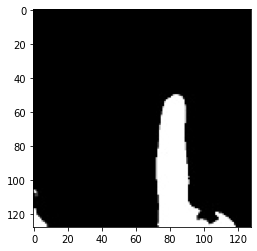

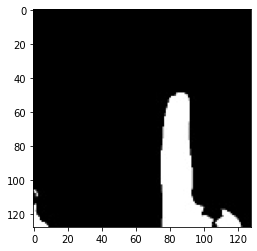

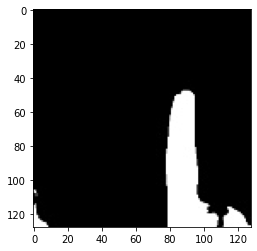

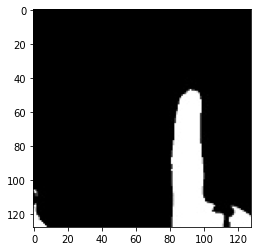

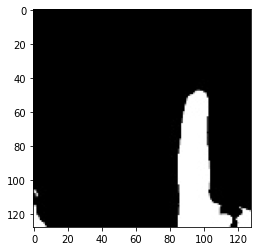

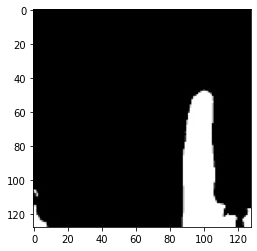

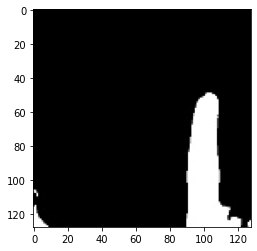

4


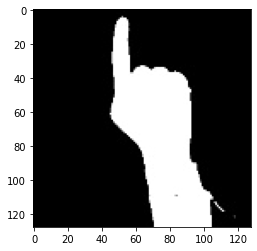

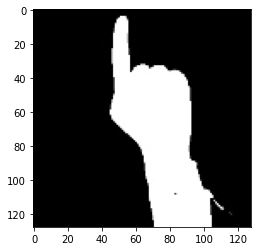

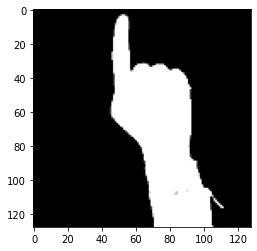

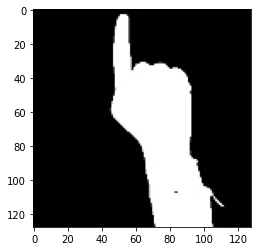

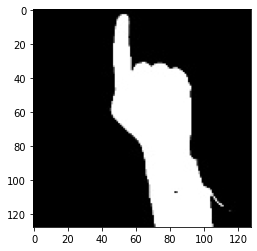

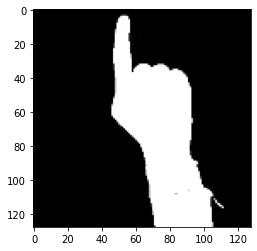

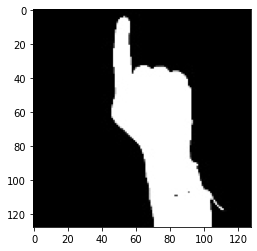

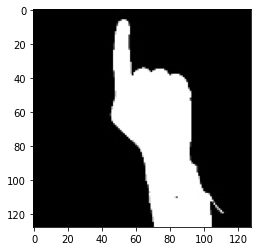

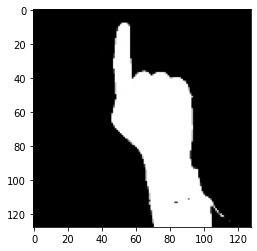

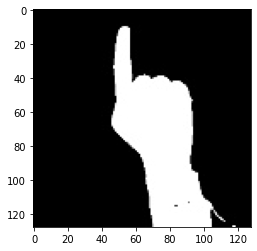

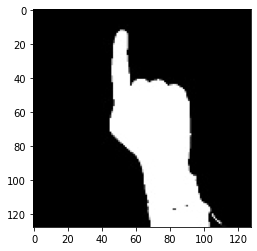

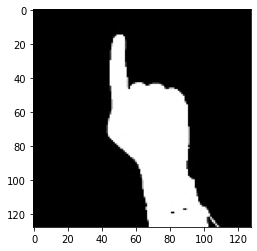

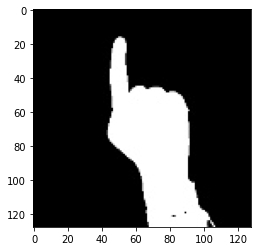

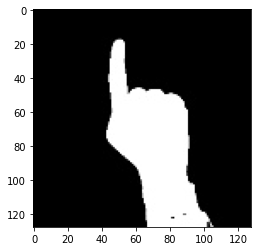

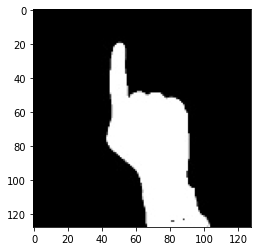

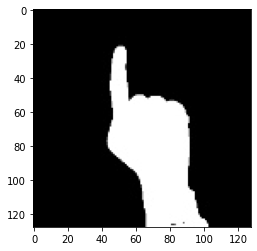

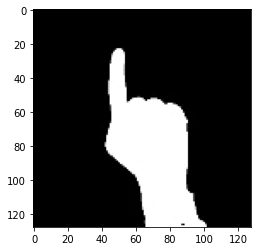

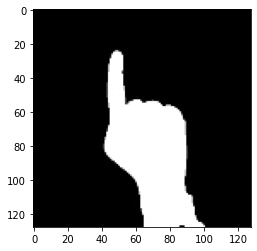

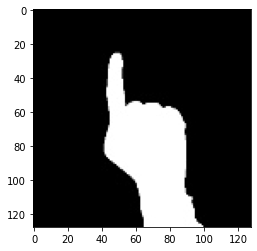

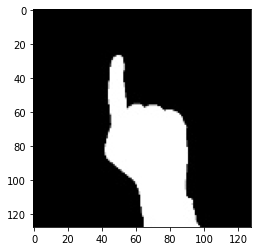

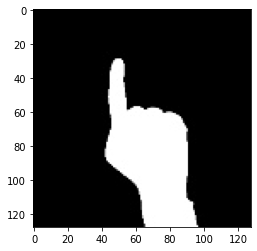

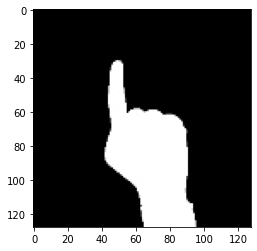

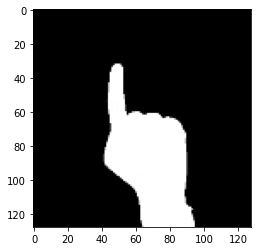

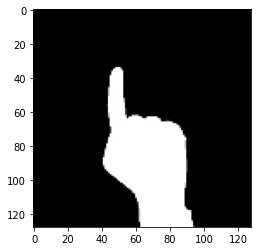

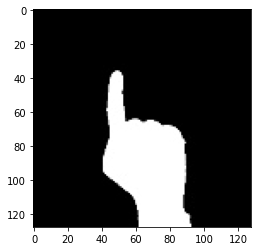

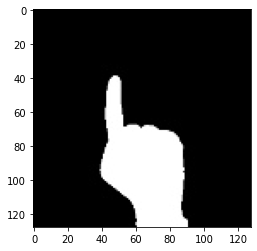

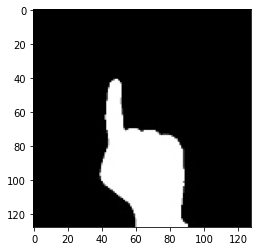

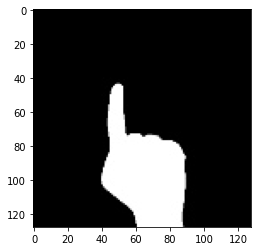

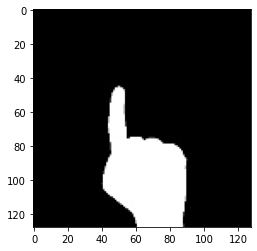

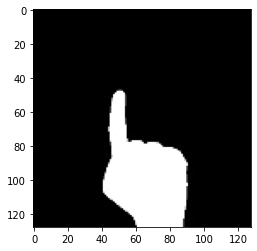

5


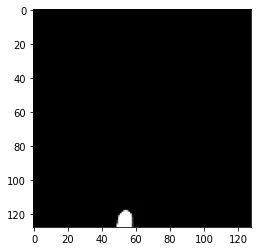

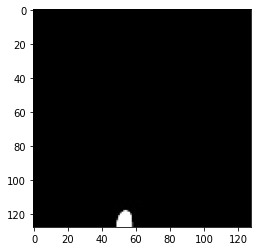

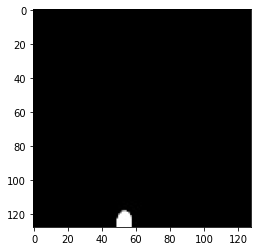

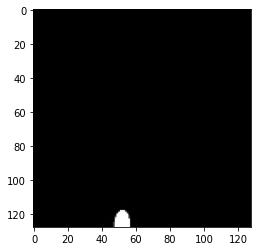

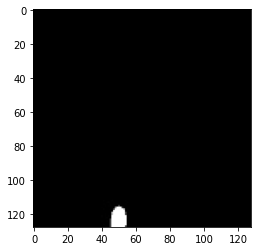

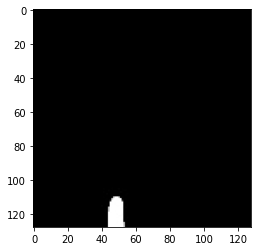

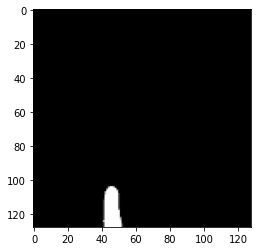

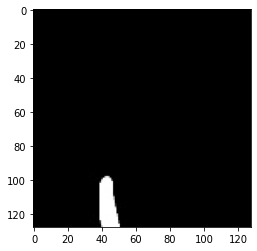

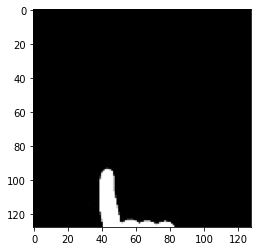

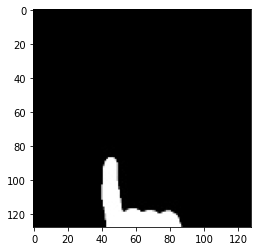

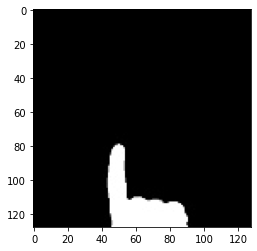

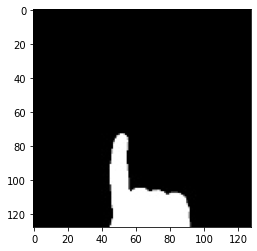

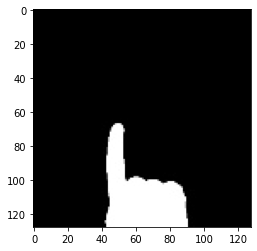

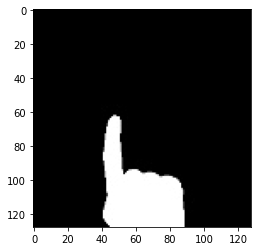

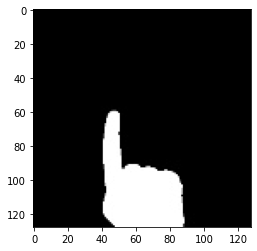

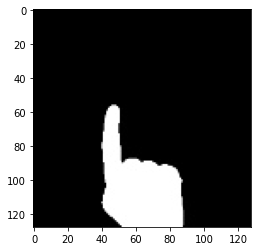

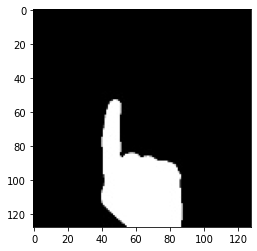

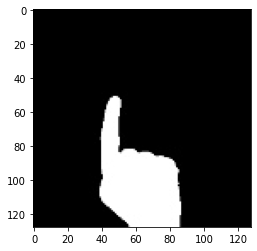

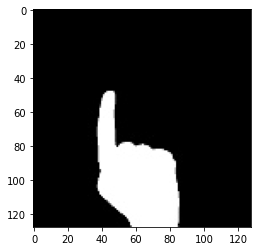

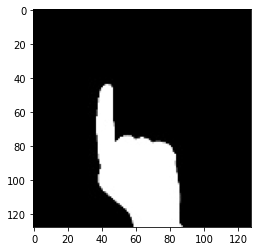

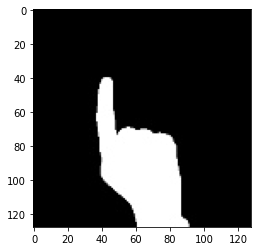

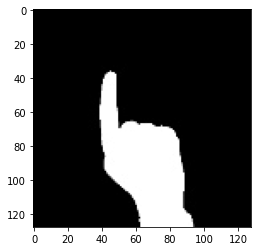

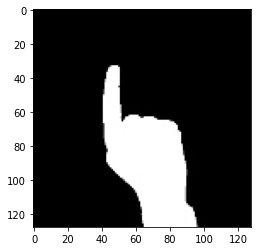

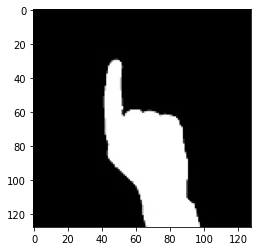

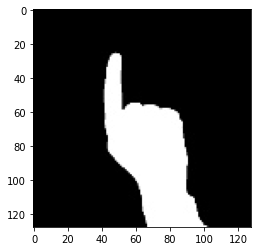

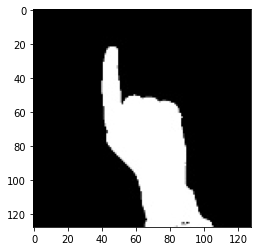

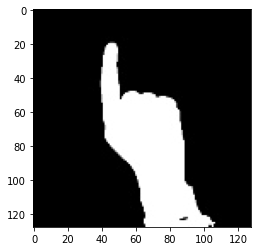

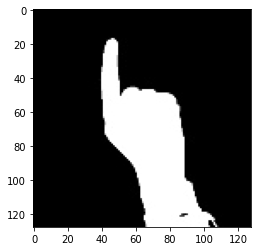

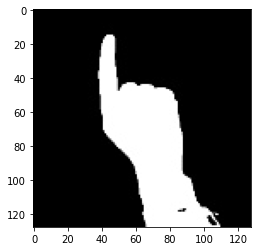

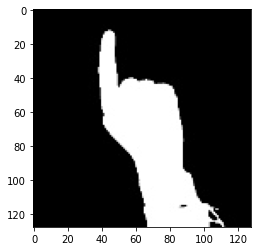

6


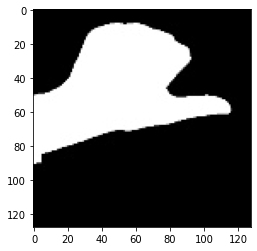

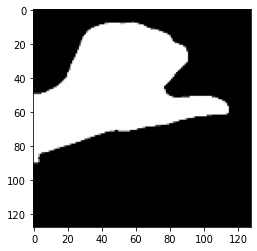

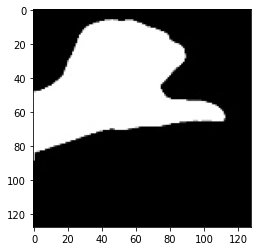

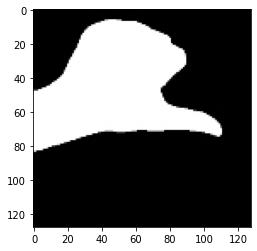

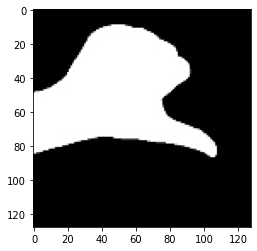

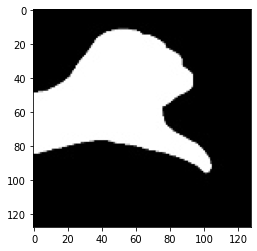

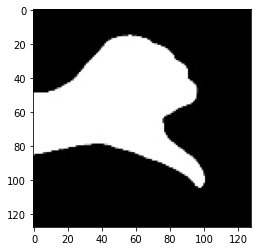

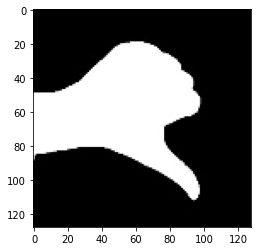

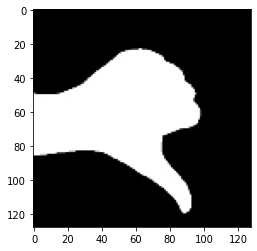

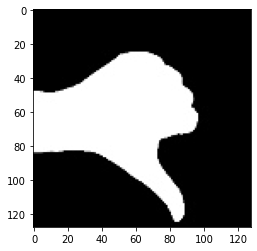

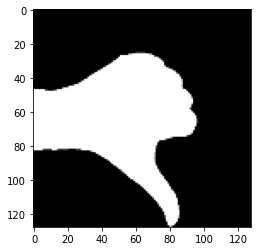

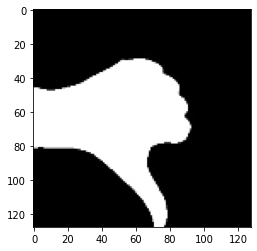

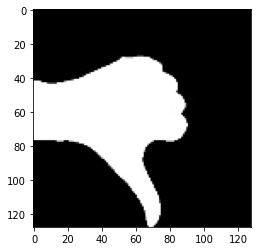

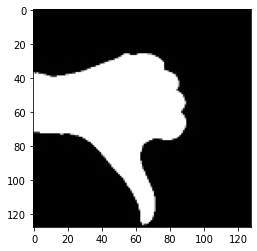

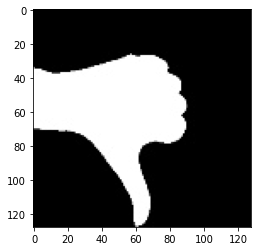

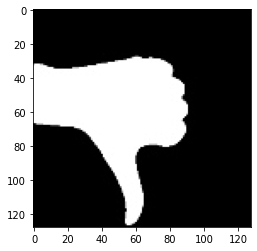

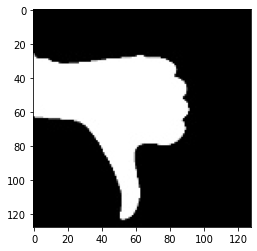

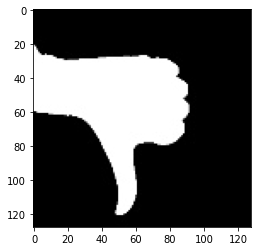

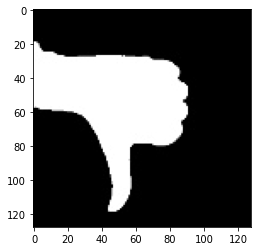

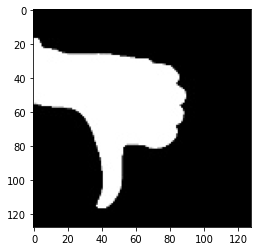

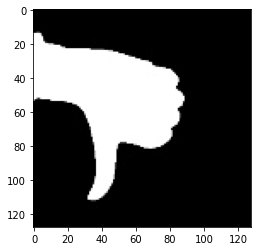

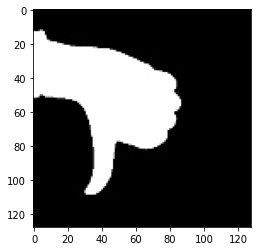

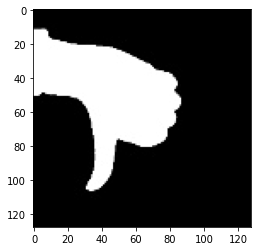

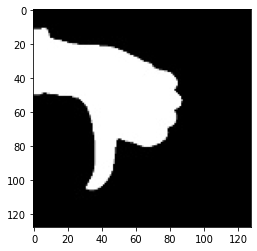

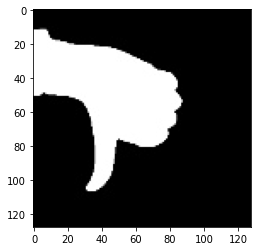

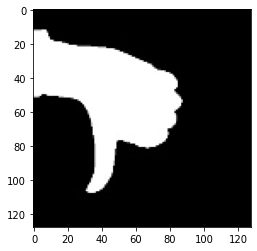

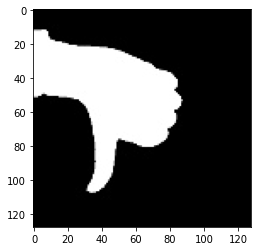

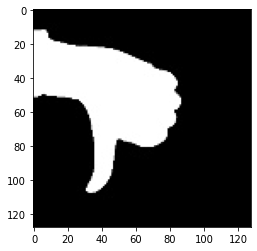

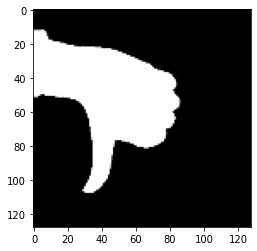

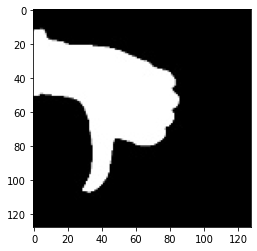

7


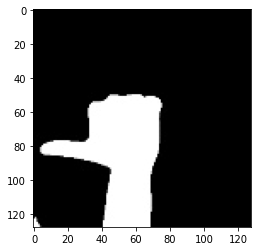

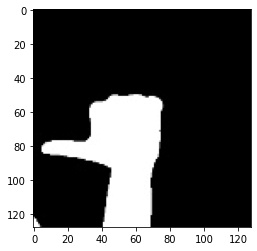

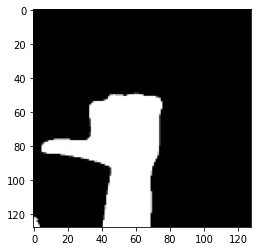

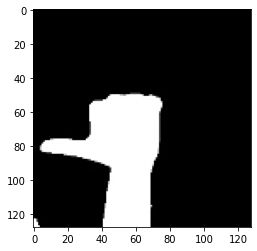

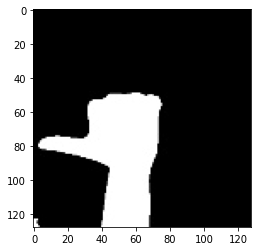

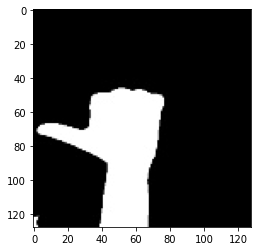

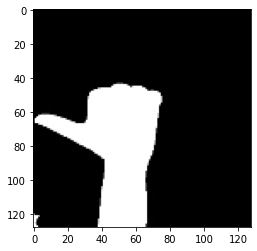

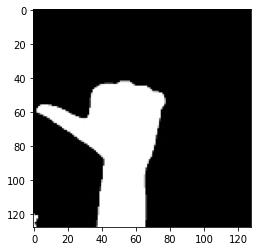

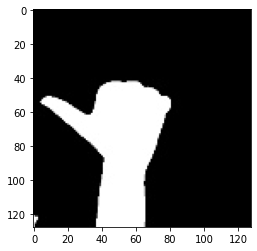

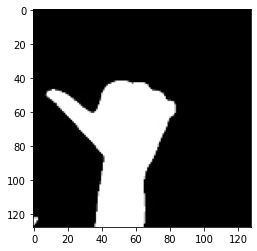

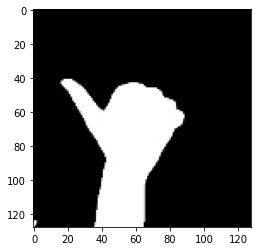

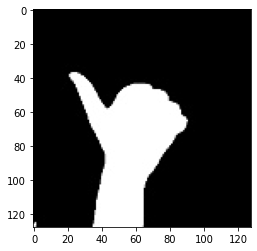

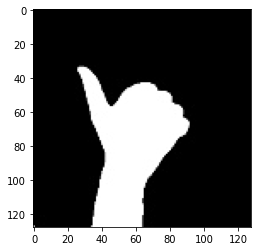

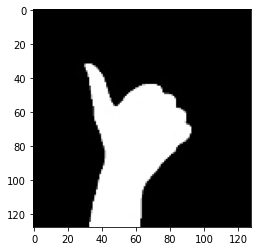

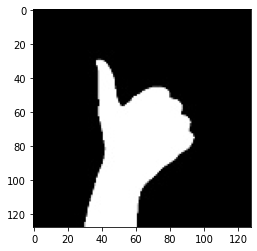

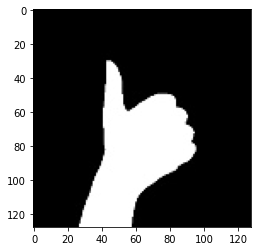

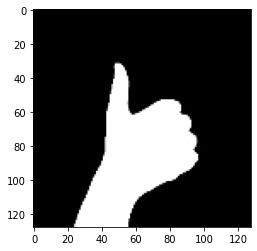

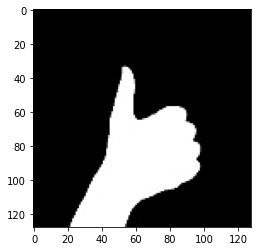

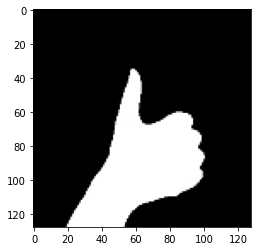

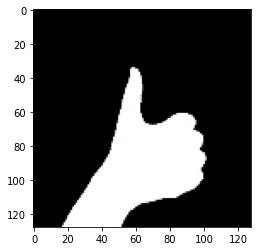

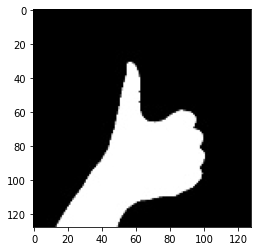

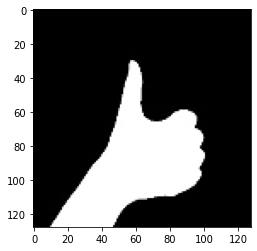

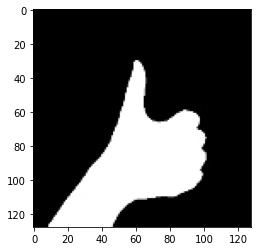

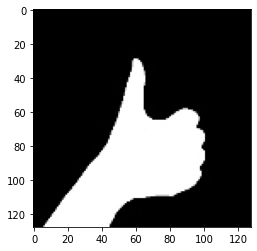

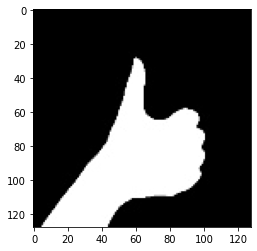

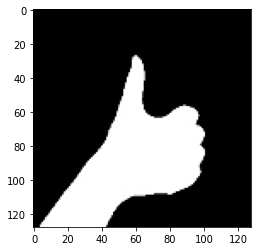

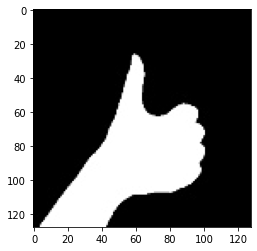

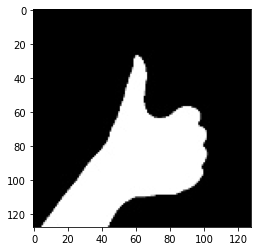

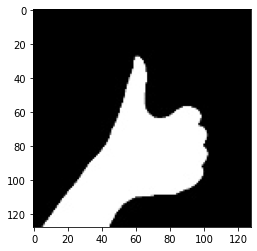

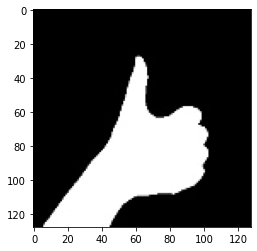

In [5]:
for j in range(8):
  idx = Y.index(j)
  print(j)
  for i in range(30):
    plt.imshow(np.squeeze(X[idx][i], axis=-1), cmap='gray')
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


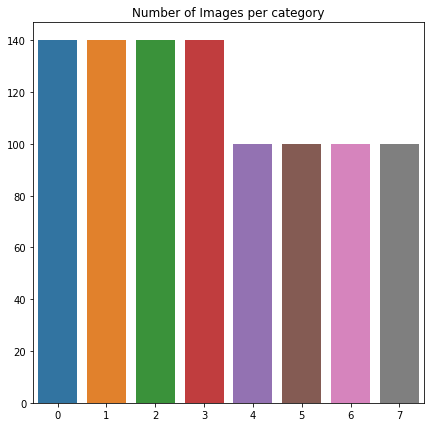

In [6]:
unique, count = np.unique(Y, return_counts=True)
figure = plt.figure(figsize=(7, 7))
sns.barplot(unique, count).set_title('Number of Images per category')
plt.show()

In [7]:
X = np.array(X)
Y = np.array(Y)

Y = to_categorical(Y)

print(X.shape)
print(Y.shape)

(960, 30, 128, 128, 1)
(960, 8)


In [8]:
np.random.seed(40)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1, shuffle=True)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(864, 30, 128, 128, 1)
(864, 8)
(96, 30, 128, 128, 1)
(96, 8)


In [9]:
model = Sequential()
model.add(Input(shape=(30, 128, 128, 1)))
model.add(Conv3D(16, (5, 5, 5), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=100), name='conv1'))
model.add(MaxPool3D((2, 2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Conv3D(32, (3, 3, 3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=100), name='conv2'))
model.add(MaxPool3D((1, 2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same', kernel_initializer=glorot_uniform(seed=100), name='conv3'))
model.add(MaxPool3D((1, 2, 2), padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(128, activation='relu', kernel_initializer=glorot_uniform(seed=100), name='fc1'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(64, activation='relu', kernel_initializer=glorot_uniform(seed=100), name='fc2'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(8, activation='softmax', kernel_initializer=glorot_uniform(seed=100), name='fc3'))

opt = Adam(learning_rate=0.001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1 (Conv3D)              (None, 30, 128, 128, 16)  2016      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 15, 64, 64, 16)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 15, 64, 64, 16)   64        
 ormalization)                                                   
                                                                 
 conv2 (Conv3D)              (None, 15, 64, 64, 32)    13856     
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 15, 32, 32, 32)   0         
 3D)                                                             
                                                        

In [10]:
checkpoint = ModelCheckpoint('hand_gesture_recognition_v3.h5', monitor='val_loss', save_best_only=True, verbose=1, mode='min')
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, verbose=1, patience=4, )

def step_decay(epoch):
    initial_learning_rate = 0.001
    dropEvery = 10
    factor = 0.5
    lr = initial_learning_rate*(factor**np.floor((1 + epoch)/dropEvery))
    return float(lr)

callbacks = [checkpoint, LR]
# callbacks = [checkpoint, LearningRateScheduler(step_decay)]

hist = model.fit(X_train, Y_train, batch_size=32, epochs=20, validation_data=(X_test, Y_test), callbacks=callbacks)

Epoch 1/20
27/27 [==============================] - ETA: 0s - loss: 0.5283 - accuracy: 0.8634
Epoch 00001: val_loss improved from inf to 0.79865, saving model to hand_gesture_recognition_v3.h5
27/27 [==============================] - 65s 2s/step - loss: 0.5283 - accuracy: 0.8634 - val_loss: 0.7987 - val_accuracy: 0.8438 - lr: 0.0010
Epoch 2/20
27/27 [==============================] - ETA: 0s - loss: 0.0653 - accuracy: 0.9954
Epoch 00002: val_loss did not improve from 0.79865
27/27 [==============================] - 46s 2s/step - loss: 0.0653 - accuracy: 0.9954 - val_loss: 1.0173 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/20
27/27 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9977
Epoch 00003: val_loss improved from 0.79865 to 0.60927, saving model to hand_gesture_recognition_v3.h5
27/27 [==============================] - 48s 2s/step - loss: 0.0381 - accuracy: 0.9977 - val_loss: 0.6093 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 4/20
27/27 [=====================

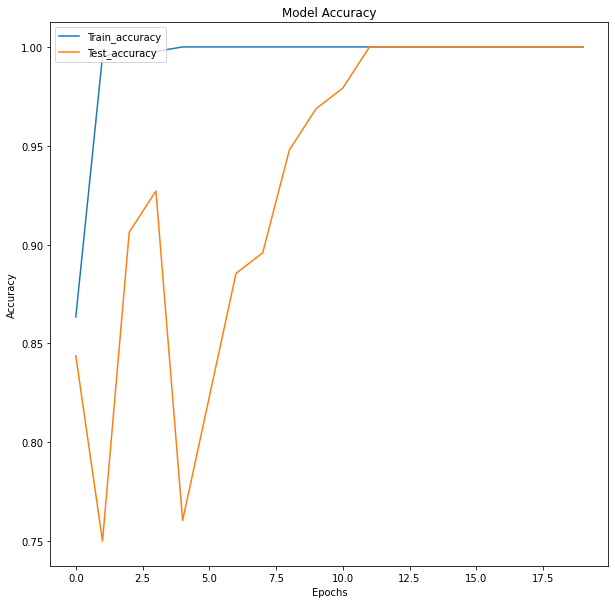

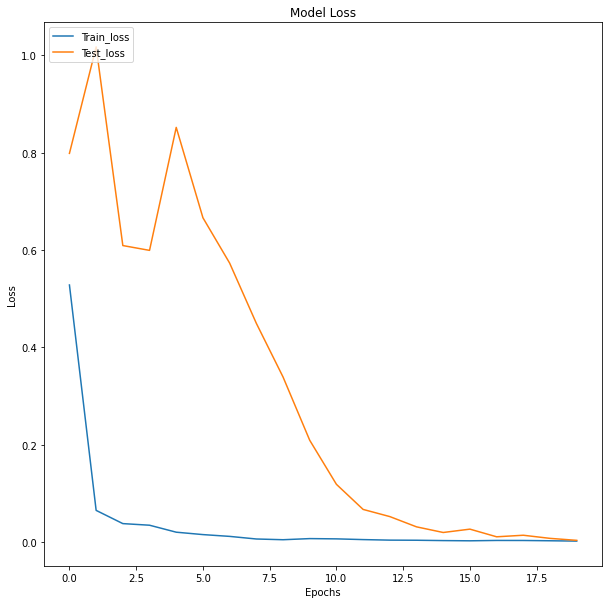

In [11]:
figure1 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['accuracy'], label='Train_accuracy')
plt.plot(hist.history['val_accuracy'], label='Test_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc="upper left")
plt.show()

figure2 = plt.figure(figsize=(10, 10))
plt.plot(hist.history['loss'], label='Train_loss')
plt.plot(hist.history['val_loss'], label='Test_loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc="upper left")
plt.show()

In [12]:
y_pred_test = model.predict(X_test)
y_pred_test = np.argmax(y_pred_test, axis=1)
Y_test_copy = np.argmax(Y_test, axis=1)
print(classification_report(Y_test_copy, y_pred_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        14
           1       1.00      1.00      1.00        13
           2       1.00      1.00      1.00        13
           3       1.00      1.00      1.00         9
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00        14
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00        14

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96



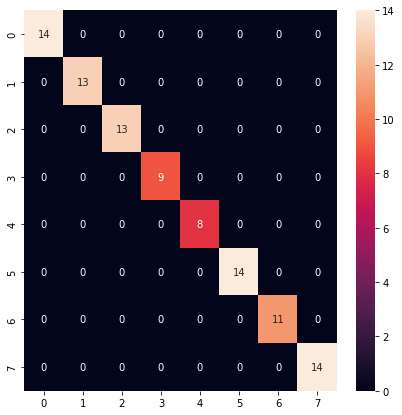

In [13]:
matrix = confusion_matrix(Y_test_copy, y_pred_test)
figure = plt.figure(figsize=(7, 7))
df = pd.DataFrame(matrix, index=[0, 1, 2, 3, 4, 5, 6, 7], columns=[0, 1, 2, 3, 4, 5, 6, 7])
sns.heatmap(df, annot=True, fmt='d')
plt.show()